In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import geopandas as gpd
import os, lzma, csv, collections, json, sys, pickle
import numpy as np
import open_cp.sources.chicago
import shapely.geometry

import tilemapbase
import pyproj
proj = pyproj.Proj({"init":"epsg:3528"})

In [2]:
data_dir = os.path.join("/media", "disk", "Data")
#data_dir = os.path.join("..", "..", "..", "..", "Data")
#os.listdir(data_dir)
filename = os.path.join(data_dir, "chicago_all.csv.xz")

In [3]:
def generate_old():
    with lzma.open(filename, "rt", encoding="utf8") as f:
        reader = csv.reader(f)
        header = next(reader)
        for row in reader:
            if row[15] == "":
                continue
            year = int(row[17])
            if year <= 2001:
                continue
            block, x, y = row[3], float(row[15]), float(row[16])
            x /= open_cp.sources.chicago._FEET_IN_METERS
            y /= open_cp.sources.chicago._FEET_IN_METERS
            if x < 10 or y < 10:
                continue
            yield (block, x, y, row[5], row[6], row[7], row[2], row[0])

In [4]:
def generate_new():
    with lzma.open("chicago_new_data_test.csv.xz", "rt") as f:
        r = csv.reader(f)
        header = next(r)
        for row in r:
            yield (row[0], float(row[1]), float(row[2]), *row[3:])

## A bit of sanity checking

In [6]:
missing_ids = []
old_data = generate_old()
for row in generate_new():
    old_row = next(old_data)
    while old_row[-1] != row[-1]:
        missing_ids.append(old_row[-1])
        old_row = next(old_data)
    assert old_row[0] == row[0]
    assert old_row[3:] == tuple(row[3:])
missing_ids

['6420602',
 '9763503',
 '9772154',
 '9816097',
 '9821435',
 '9834102',
 '9836869',
 '9861772',
 '9883070',
 '9892665',
 '9896387',
 '1981069',
 '10517994',
 '10836475',
 '10993498']

# Just capture `block` and old/new coords

In [5]:
blocks, old_xy, new_xy = [], [], []

old_data = generate_old()
for row in generate_new():
    old_row = next(old_data)
    while old_row[-1] != row[-1]:
        old_row = next(old_data)
    blocks.append(row[0])
    old_xy.append((old_row[1], old_row[2]))
    new_xy.append((row[1], row[2]))

old_xy = np.asarray(old_xy)
new_xy = np.asarray(new_xy)

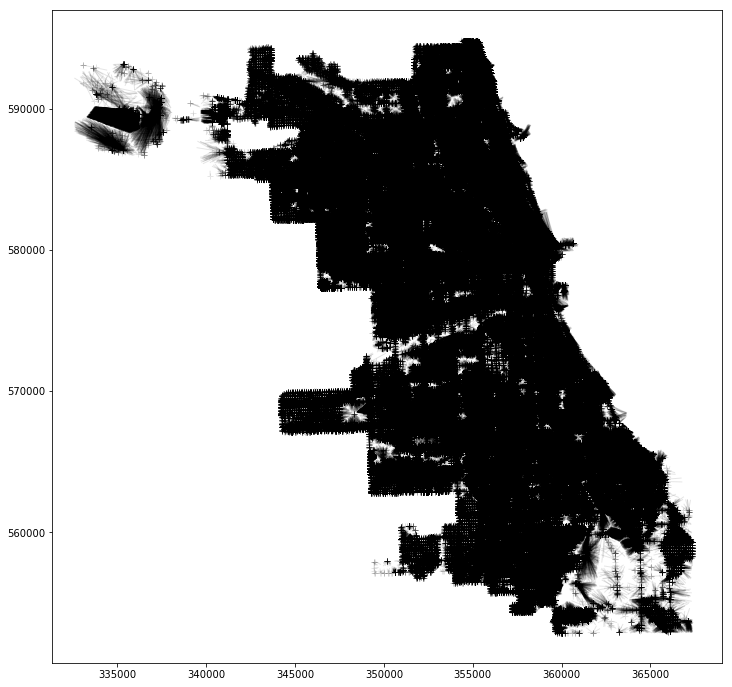

In [8]:
import matplotlib.collections

fig, ax = plt.subplots(figsize=(12,12))

ax.scatter(*old_xy.T, marker="+", linewidth=1, alpha=0.1, color="black")

c = matplotlib.collections.LineCollection(list(zip(old_xy, new_xy)), linewidth=1, alpha=0.1, color="black")
ax.add_collection(c)

[(580000, 600000), (325000, 345000)]

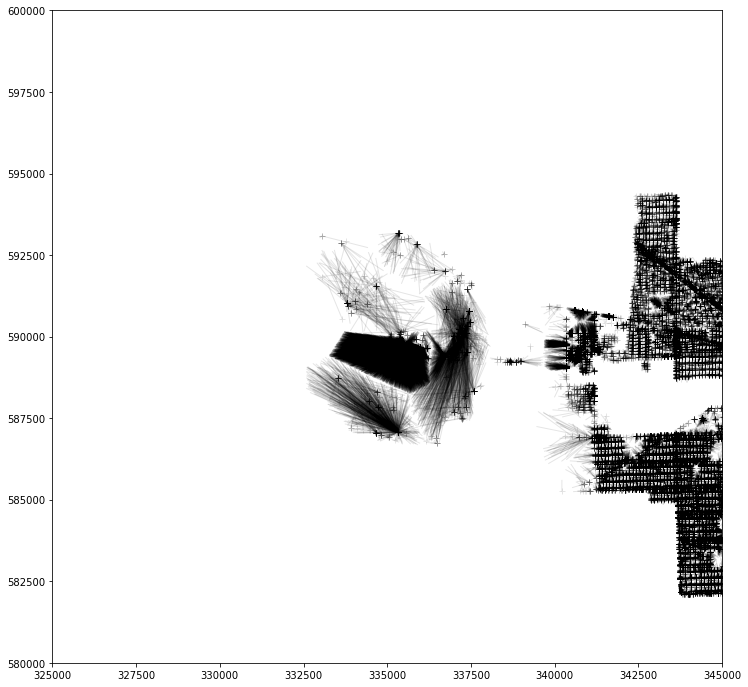

In [9]:
fig, ax = plt.subplots(figsize=(12,12))

ax.scatter(*old_xy.T, marker="+", linewidth=1, alpha=0.1, color="black")

c = matplotlib.collections.LineCollection(list(zip(old_xy, new_xy)), linewidth=1, alpha=0.1, color="black")
ax.add_collection(c)
x, y, d = 335000, 590000, 10000
ax.set(xlim=[x-d,x+d], ylim=[y-d,y+d])

[(569000, 571000), (354000, 356000)]

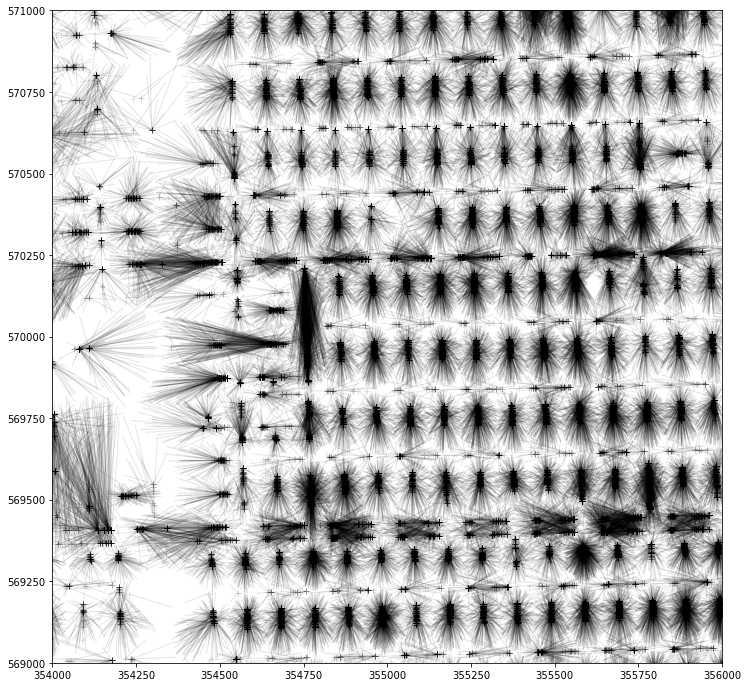

In [10]:
fig, ax = plt.subplots(figsize=(12,12))

ax.scatter(*old_xy.T, marker="+", linewidth=1, alpha=0.1, color="black")

c = matplotlib.collections.LineCollection(list(zip(old_xy, new_xy)), linewidth=1, alpha=0.1, color="black")
ax.add_collection(c)
x, y, d = 355000, 570000, 1000
ax.set(xlim=[x-d,x+d], ylim=[y-d,y+d])

What we see is that some points are moved too far really.

In [6]:
diffs_frame = gpd.GeoDataFrame({"block":blocks})
diffs_frame.geometry = [shapely.geometry.LineString([list(st), list(en)])
                        for st, en in zip(old_xy, new_xy)]
diffs_frame.crs = {"init":"epsg:3528"}

In [8]:
diffs_frame.to_file("chicago_first_synthetic")